# SSP-MMC for FSRS

SSP-MMC stands for "Stochastic-Shortest-Path-Minimize-Memorization-Cost". It is a reinforcement learning algorithm that is designed to minimize the cost of memorization in the context of spaced repetition. This is a re-implementation of the original SSP-MMC algorithm in Numpy. The memory model is updated to FSRS instead of DHP-HLR.

Original code: https://github.com/maimemo/SSP-MMC

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

again_cost = 25
hard_cost = 14
good_cost = 10
easy_cost = 6
first_rating_prob = np.array([0.15, 0.2, 0.6, 0.05])
review_rating_prob = np.array([0.3, 0.6, 0.1])

s_min = 0.1
s_max = 365
s_eps = 0.4
s_size = np.ceil((s_max - s_min) / s_eps + 1).astype(int)

d_min = 1
d_max = 10
d_eps = 0.3
d_size = np.ceil((d_max - d_min) / d_eps + 1).astype(int)

r_min = 0.69
r_max = 0.96
r_eps = 0.03
r_size = np.ceil((r_max - r_min) / r_eps + 1).astype(int)

DECAY = -0.5
FACTOR = 0.9 ** (1.0 / DECAY) - 1.0


def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY


def next_interval(s, r):
    ivl = s / FACTOR * (r ** (1.0 / DECAY) - 1.0)
    return np.maximum(1, np.floor(ivl))


cost_matrix = np.zeros((d_size, s_size))
cost_matrix.fill(1000)
cost_matrix[:, -1] = 0
action_matrix = np.zeros((d_size, s_size))

w = [
    0.5701, 1.4436, 4.1386, 10.9355,
    5.1377, 1.225, 0.8735, 0.0375,
    1.647, 0.1361, 1.0293,
    2.1111, 0.0864, 0.323, 1.4188,
    0.219, 2.8467
]


def stability_after_success(s, d, r, g):
    return s * (
        1
        + np.exp(w[8])
        * (11 - d)
        * np.power(s, -w[9])
        * (np.exp((1 - r) * w[10]) - 1)
        * (w[15] if g == 2 else 1)
        * (w[16] if g == 4 else 1)
    )


def stability_after_failure(s, d, r):
    return np.minimum(
        w[11]
        * np.power(d, -w[12])
        * (np.power(s + 1, w[13]) - 1)
        * np.exp((1 - r) * w[14]),
        s,
    )


def mean_reversion(init, current):
    return (w[7] * init + (1 - w[7]) * current).clip(1, 10)


def next_difficulty(d, g):
    return mean_reversion(w[4], d - w[6] * (g - 3))


# stability to index
def s2i(s): return np.clip(np.floor((s - s_min) /
                                    (s_max - s_min) * s_size).astype(int), 0, s_size - 1)


# difficulty to index
def d2i(d): return np.clip(np.floor((d - d_min) /
                                    (d_max - d_min) * d_size).astype(int), 0, d_size - 1)


# retention to index
def r2i(r): return np.clip(np.floor((r - r_min) /
                                    (r_max - r_min) * r_size).astype(int), 0, r_size - 1)

# indexes to cost


def i2c(s, d): return cost_matrix[d2i(d), s2i(s)]

In [2]:
i = 0
diff = 10000
n_iter = 1000

start = time.time()

s_state = np.linspace(s_min, s_max, s_size)
d_state = np.linspace(d_min, d_max, d_size)
r_state = np.linspace(r_min, r_max, r_size)

s_state_mesh, d_state_mesh, r_state_mesh = np.meshgrid(
    s_state, d_state, r_state)

ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

while i < n_iter and diff > 1e-4 * s_size * d_size:
    next_stability_after_again = stability_after_failure(
        s_state_mesh, d_state_mesh, r_state_mesh
    )
    next_difficulty_after_again = next_difficulty(d_state_mesh, 1)
    next_cost_after_again = (
        i2c(next_stability_after_again, next_difficulty_after_again) + again_cost
    )

    next_stability_after_hard = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh, 2
    )
    next_difficulty_after_hard = next_difficulty(d_state_mesh, 2)
    next_cost_after_hard = (
        i2c(next_stability_after_hard, next_difficulty_after_hard) + hard_cost
    )

    next_stability_after_good = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh, 3
    )
    next_difficulty_after_good = next_difficulty(d_state_mesh, 3)
    next_cost_after_good = (
        i2c(next_stability_after_good, next_difficulty_after_good) + good_cost
    )

    next_stability_after_easy = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh, 4
    )
    next_difficulty_after_easy = next_difficulty(d_state_mesh, 4)
    next_cost_after_easy = (
        i2c(next_stability_after_easy, next_difficulty_after_easy) + easy_cost
    )

    expected_cost = (
        r_state_mesh
        * (
            review_rating_prob[0] * next_cost_after_hard
            + review_rating_prob[1] * next_cost_after_good
            + review_rating_prob[2] * next_cost_after_easy
        )
        + (1 - r_state_mesh) * next_cost_after_again
    )
    # update cost matrix
    optimal_cost = np.minimum(cost_matrix, expected_cost.min(axis=2))
    retention_matrix = r_state[np.argmin(expected_cost, axis=2)]
    diff = cost_matrix.sum() - optimal_cost.sum()
    cost_matrix = optimal_cost
    if i % 10 == 0:
        print(
            f"iteration {i:>5}, diff {diff:.2f}, time {time.time() - start:.2f}s")
    i += 1

end = time.time()
print(f"Time: {end - start:.2f}s")
init_stability = np.array(w[0:4])
init_difficulty = np.array([w[4] - (3 - g) * w[5] for g in range(1, 5)])
init_cost = cost_matrix[d2i(init_difficulty), s2i(init_stability)]
avg_cost = init_cost @ first_rating_prob
print(f"Average cost: {avg_cost:.2f}")
avg_retention = retention_matrix.mean()
print(f"Average retention: {avg_retention:.2f}")

iteration     0, diff 17317937.28, time 0.09s
iteration    10, diff 88539.48, time 0.91s
iteration    20, diff 46729.94, time 1.60s
iteration    30, diff 29221.21, time 2.41s
iteration    40, diff 18792.07, time 3.34s
iteration    50, diff 12137.84, time 4.40s
iteration    60, diff 7844.29, time 5.09s
iteration    70, diff 5070.27, time 5.96s
iteration    80, diff 3277.25, time 6.71s
iteration    90, diff 2117.93, time 7.41s
iteration   100, diff 1368.70, time 8.13s
iteration   110, diff 884.48, time 8.90s
iteration   120, diff 571.55, time 9.59s
iteration   130, diff 369.29, time 10.24s
iteration   140, diff 238.60, time 11.36s
iteration   150, diff 154.16, time 12.02s
iteration   160, diff 99.60, time 12.90s
iteration   170, diff 64.35, time 13.88s
iteration   180, diff 41.57, time 14.47s
iteration   190, diff 26.86, time 15.51s
iteration   200, diff 17.35, time 16.12s
iteration   210, diff 11.21, time 16.77s
iteration   220, diff 7.24, time 17.65s
iteration   230, diff 4.68, time 18

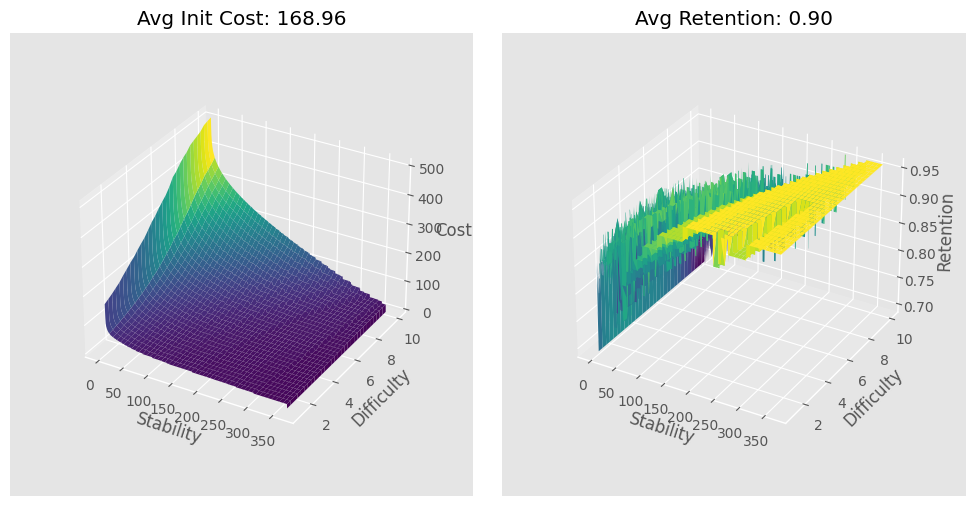

In [3]:
s_state_mesh_2d, d_state_mesh_2d = np.meshgrid(s_state, d_state)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, cost_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Cost")
ax.set_title(f"Avg Init Cost: {avg_cost:.2f}")
ax.set_box_aspect(None, zoom=0.8)
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d,
                retention_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Retention")
ax.set_title(f"Avg Retention: {avg_retention:.2f}")
ax.set_box_aspect(None, zoom=0.8)
plt.tight_layout()
plt.show()

Retention: 69.00%
Time: 1.58s, Iterations: 332


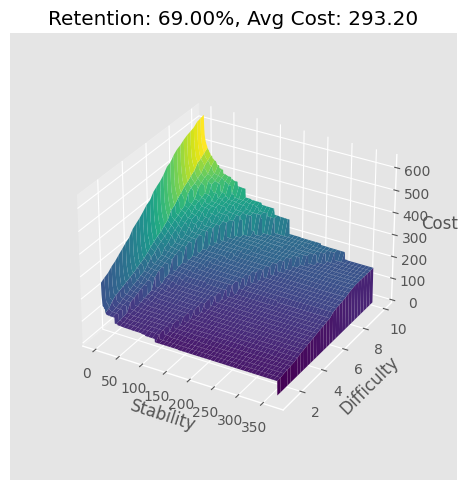

Retention: 72.00%
Time: 1.91s, Iterations: 324


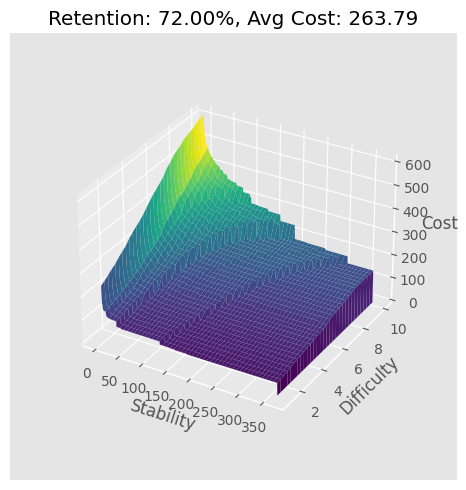

Retention: 75.00%
Time: 1.56s, Iterations: 317


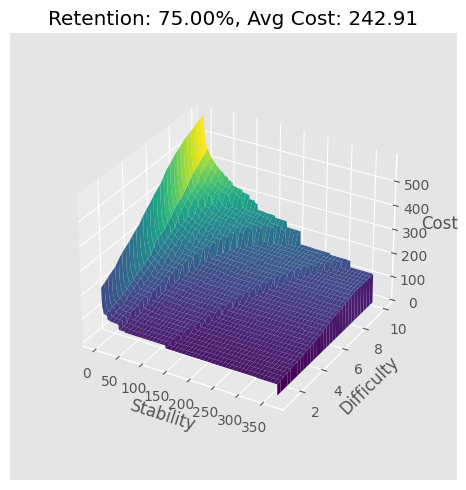

Retention: 78.00%
Time: 1.55s, Iterations: 317


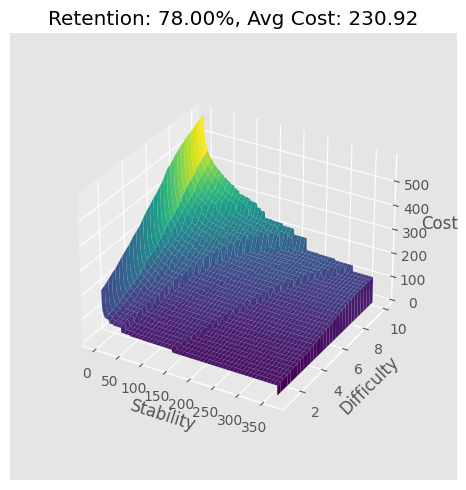

Retention: 81.00%
Time: 1.33s, Iterations: 317


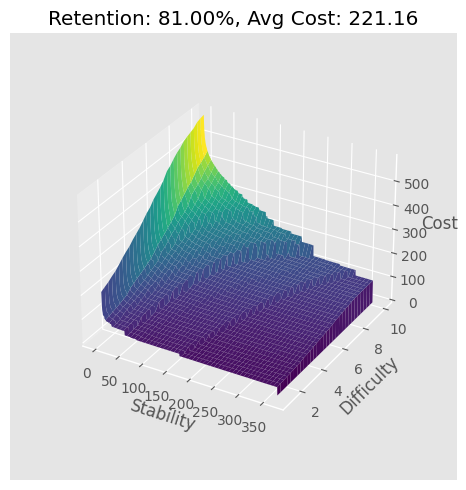

Retention: 84.00%
Time: 1.60s, Iterations: 327


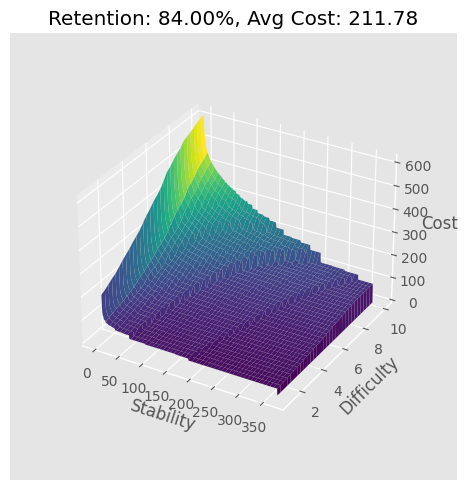

Retention: 87.00%
Time: 1.66s, Iterations: 342


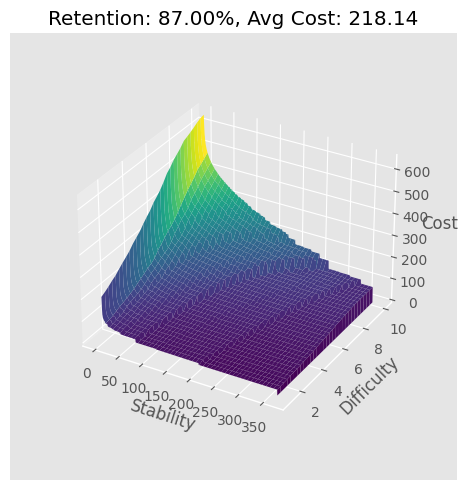

Retention: 90.00%
Time: 1.87s, Iterations: 368


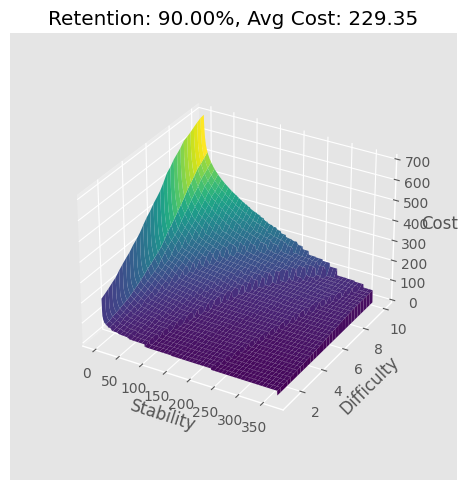

Retention: 93.00%
Time: 2.17s, Iterations: 413


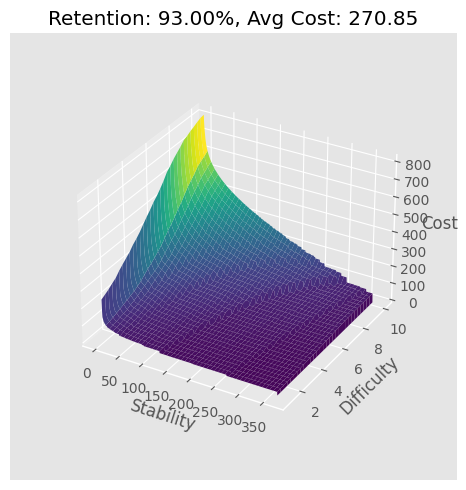

Retention: 96.00%
Time: 1.53s, Iterations: 318


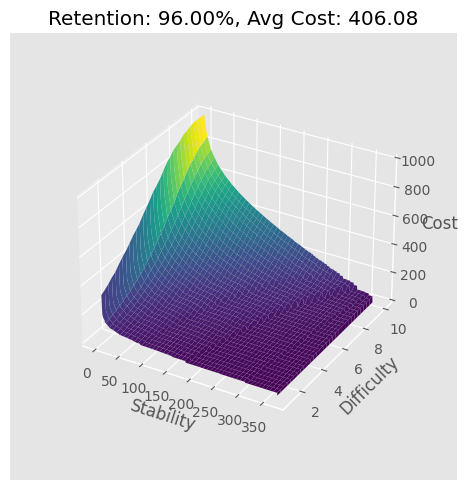

In [4]:
costs = []

r_range = np.linspace(r_min, r_max, 10)

for r in r_range:
    start = time.time()
    print(f"Retention: {r * 100:.2f}%")
    cost_matrix = np.zeros((d_size, s_size))
    cost_matrix.fill(1000)
    cost_matrix[:, -1] = 0
    s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
    r_state_mesh = r * np.ones((d_size, s_size))
    ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
    r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

    i = 0
    diff = 10000
    n_iter = 1000
    while i < n_iter and diff > 1e-4 * s_size * d_size:
        next_stability_after_again = stability_after_failure(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_again = next_difficulty(d_state_mesh, 1)
        next_cost_after_again = (
            i2c(next_stability_after_again, next_difficulty_after_again) + again_cost
        )

        next_stability_after_hard = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 2
        )
        next_difficulty_after_hard = next_difficulty(d_state_mesh, 2)
        next_cost_after_hard = (
            i2c(next_stability_after_hard, next_difficulty_after_hard) + hard_cost
        )

        next_stability_after_good = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 3
        )
        next_difficulty_after_good = next_difficulty(d_state_mesh, 3)
        next_cost_after_good = (
            i2c(next_stability_after_good, next_difficulty_after_good) + good_cost
        )

        next_stability_after_easy = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 4
        )
        next_difficulty_after_easy = next_difficulty(d_state_mesh, 4)
        next_cost_after_easy = (
            i2c(next_stability_after_easy, next_difficulty_after_easy) + easy_cost
        )

        expected_cost = (
            r_state_mesh
            * (
                review_rating_prob[0] * next_cost_after_hard
                + review_rating_prob[1] * next_cost_after_good
                + review_rating_prob[2] * next_cost_after_easy
            )
            + (1 - r_state_mesh) * next_cost_after_again
        )
        # update cost matrix
        optimal_cost = np.minimum(cost_matrix, expected_cost)
        diff = cost_matrix.sum() - optimal_cost.sum()
        cost_matrix = optimal_cost
        i += 1
    end = time.time()
    print(f"Time: {end - start:.2f}s, Iterations: {i}")
    init_stability = np.array(w[0:4])
    init_difficulty = np.array([w[4] - (3 - g) * w[5] for g in range(1, 5)])
    init_cost = cost_matrix[d2i(init_difficulty), s2i(init_stability)]
    avg_cost = init_cost @ first_rating_prob
    costs.append(avg_cost)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
    ax.set_xlabel("Stability")
    ax.set_ylabel("Difficulty")
    ax.set_zlabel("Cost")
    ax.set_title(f"Retention: {r * 100:.2f}%, Avg Cost: {avg_cost:.2f}")
    ax.set_box_aspect(None, zoom=0.8)
    plt.tight_layout()
    plt.show()

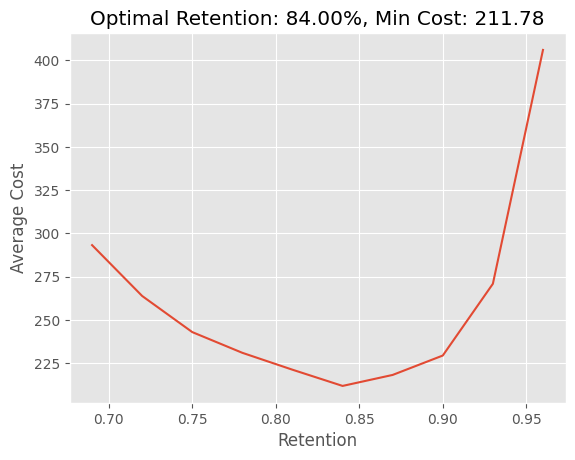

In [5]:
optimal_retention = r_range[np.argmin(costs)]
min_cost = np.min(costs)
plt.plot(r_range, costs)
plt.xlabel("Retention")
plt.ylabel("Average Cost")
plt.title(
    f"Optimal Retention: {optimal_retention * 100:.2f}%, Min Cost: {min_cost:.2f}"
)
plt.show()